In [1]:
#-------------------------------#
#--- Load Required Libraries ---#
#-------------------------------#

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Directory # 
wd = '/Users/kirankrishnamurthi/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Projects/NBA End of Season Streak Project'
os.chdir(wd)

#-- Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

#-- Load in Data 
data = pd.read_csv('nba_2021_2022_game_logs.csv', parse_dates = ['Date']).sort_values(by = 'Date')

In [40]:
#---------------------------------------------------------------------------#
#                  Column Initialization and Cleanup                        #
#---------------------------------------------------------------------------#

#-- Preserve Indexing Columns
data['Game'] = data['G']
data['Team'] = data['gamelog_team']

#-- Set the Index
data = data.set_index(['Game', 'Team'])

#-- Create Gamelog Primary Key
data['primary_key'] = data['gamelog_team'] + "_" + data['G'].map(str) + "_" + data['Opp_Team'] + '_' + (data.groupby('Opp_Team').cumcount() + 1).map(str)

#-- Reset Home and Away Column
data['H_A'] = np.where(data['H_A'] == '@', 'AWAY', 'HOME')

#-- Create an array of just the teams
teams_array = data['gamelog_team'].unique()

#-- Creating a binary win / loss column 
data['win_binary'] = np.where(data['W_L'] == 'W', 1, 0)

#-- Create winning accumulation and percentage change columns
data['win_total'] = data.groupby(by = 'gamelog_team').win_binary.cumsum()
data['win_pct'] = (data['win_total'] / data['G']) 

#-- Create a primary key for the matchup with the opponent name and game ID
data['opp_win_pct_pkey'] = data['G'].map(str) + '_' + data['Opp_Team']

#---------------------------------------------------------------------------#
#                  Calculate Opponent Win Percentages                       #
#---------------------------------------------------------------------------#

data_win_pct = pd.pivot_table(data = data,
                index = ['G', 'gamelog_team'],
                values = 'win_pct',
                aggfunc = np.sum).reset_index().sort_values(by = ['gamelog_team', 'G'])

data_win_pct['opp_win_pct_pkey'] = data_win_pct['G'].map(str) + "_" + data_win_pct['gamelog_team']

data_win_pct.set_index('opp_win_pct_pkey', inplace = True)
data_win_pct['opp_win_pct'] = data_win_pct['win_pct']

#-- Merge all data together --# 
data = data.join(data_win_pct['opp_win_pct'], on = 'opp_win_pct_pkey', how = 'left', lsuffix='_team', rsuffix='_opponent')

#---------------------------------------------------------------------------#
#                       Calculate Winning Streaks                           #
#---------------------------------------------------------------------------#

def not_equal(inser):
    inser_shifted = inser.shift(periods = 1)
    outser = inser.ne(inser_shifted)
    return outser

data['win_binary_shift'] = data.groupby('Team').win_binary.shift(periods = 1)
data['start_of_streak'] = data['win_binary'].groupby('Team').apply(not_equal)
data['streak_id'] = data['start_of_streak'].groupby('Team').cumsum()
data['streak_counter'] = data.groupby(['Team', 'streak_id']).cumcount() + 1

#---------------------------------------------------------------------------#
#                      Code in the Momentum Model                           #
#---------------------------------------------------------------------------#

#- Need to build the following parameters
    #- Theta = 3PM / (1 - 3P%)
    #- Delta P = Tm - Opp
    #- Zeta = Streak Counter
    #- Gamma = Function on G
    #- Omega Win = log(1 / ( 1 - np.minimum(win_pct_y, .99)) ) + 1
    #- Omega Loss = log(1 / np.minimum(win_pct_y, .99)) + 1

#----------- Old Model ----------------# 
data['MV1_D'] = data['Tm'] - data['Opp']
data['MV1_G'] = data['G']
data['MV1_S'] = data['streak_counter']

data['MV1_m'] = data['MV1_D'] * data['MV1_G'] * data['MV1_S']
data['MV1_M'] = data['MV1_m'].groupby('Team').cumsum()

#----------- New Model -----------------# 
data['Theta'] = np.sqrt( data['3P'] / (1 - data['3Pper']) )
data['Delta_P'] = (data['Tm'] - data['Opp']) / np.log10( ((data['Tm'] + data['Opp']) / 2).expanding().mean() )

data['sgn_x'] = np.sign((data['Tm'] - data['Opp']))
data['Zeta'] = data['streak_counter'] * data['sgn_x']

data['Gamma1'] = ( np.log( (data['G'] ** 3 / 3) - \
                    ((64 * data['G'] ** 2) / 2) + \
                        (943 * data['G'])) - \
                            2.4 )

data['Gamma2'] = ( -1 * ( np.cos( 
                        (2 * np.pi * \
                            ( np.abs(data['G'] - 41) / 41 ) 
                            ) ) * \
                                1 ) + 5.85 )

data['Gamma3'] = ( np.sqrt( data['Gamma1'] ** (1.2 + data['G'] / 82)) )

data['Gamma'] = np.nan

data.loc[data['G'] < 24, 'Gamma'] = data.loc[data['G'] < 24, 'Gamma1']
data.loc[(data['G'] >= 24) & (data['G'] <= 61), 'Gamma'] = data.loc[(data['G'] >= 24) & (data['G'] <= 61), 'Gamma2']
data.loc[data['G'] > 61, 'Gamma'] = data.loc[data['G'] > 61, 'Gamma3']

data['Gamma_Scaled'] = (data['Gamma'] - data['Gamma'].min()) / (data['Gamma'].max() - data['Gamma'].min())

data['OmegaW'] = np.log( 1 / (1 - np.minimum(data['opp_win_pct'], .99)) ) + 1
data['OmegaL'] = np.log( 1 / np.maximum(data['opp_win_pct'], .01) ) + 1

data['Omega'] = np.where(data['Delta_P'] < 0
                            , data['OmegaL']
                            , data['OmegaW'])

data['Lambda'] = 1
data.loc[(data['H_A'] == 'AWAY') & (data['win_binary'] == 1), 'Lambda'] = 1.25
data.loc[(data['H_A'] == 'HOME') & (data['win_binary'] == 0), 'Lambda'] = 1.25

data['Term1'] = data['Theta'] + ( data['Delta_P'] * data['Omega'] )
data['Term2'] = data['Zeta'] * data['Gamma'] * data['Lambda']

data['m'] = ( data['Theta'] + ( data['Delta_P'] * data['Omega'] ) ) + (data['Zeta'] * data['Gamma'] *  data['Lambda'])
data['M'] = data['m'].groupby('Team').cumsum()

#---------------------------------------------------------------------------#
#                      Define Vars for Plotting                             #
#---------------------------------------------------------------------------#

ec_playoff = ['MIA', 'BOS', 'MIL', 'PHI', 'TOR', 'CHI', 'BRK', 'ATL']
wc_playoff = ['PHO', 'MEM', 'GSW', 'DAL', 'UTA', 'DEN', 'MIN', 'NOP']

ec_playin = ['BRK', 'CLE', 'ATL', 'CHO']
wc_playin = ['LAC', 'MIN', 'NOP', 'SAS']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)



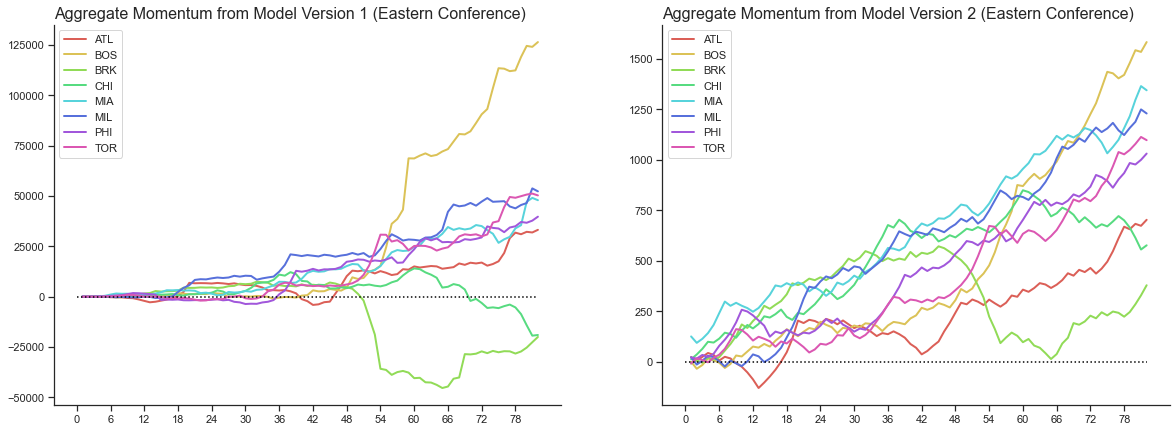

In [13]:
#---------------------------------------------------------------------------#
#                 Eastern Conference Momentum Model Comparison              #
#---------------------------------------------------------------------------#

fig, ax = plt.subplots(1, 2, sharex = True, figsize = (20, 7))
fontparams = {'font' : 'Arial', 'fontsize' : 16}

#-------------------- Model Version 1 --------------------------------------#

sns.set_palette(sns.color_palette('hls', 8))

ax[0].plot(data.loc[data.index.get_level_values('Team').isin(ec_playoff), 'MV1_M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'MV1_M'
    , index = 'Game'
    , aggfunc = np.sum
), linewidth = 2)

ax[0].legend(data.loc[data.index.get_level_values('Team').isin(ec_playoff), 'MV1_M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'MV1_M'
    , index = 'Game'
    , aggfunc = np.sum
).columns)

ax[0].set_title('Aggregate Momentum from Model Version 1 (Eastern Conference)'
                , fontdict = fontparams
                , loc = 'left')

ax[0].hlines(y = 0, xmin = 0, xmax = 82, color = 'black', linestyle = ':', alpha = 1)

#-------------------- Model Version 2 --------------------------------------#

ax[1].plot(data.loc[data.index.get_level_values('Team').isin(ec_playoff), 'M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'M'
    , index = 'Game'
    , aggfunc = np.sum
), linewidth = 2)

ax[1].legend(data.loc[data.index.get_level_values('Team').isin(ec_playoff), 'M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'M'
    , index = 'Game'
    , aggfunc = np.sum
).columns)

ax[1].hlines(y = 0, xmin = 0, xmax = 82, color = 'black', linestyle = ':', alpha = 1)

ax[1].set_title('Aggregate Momentum from Model Version 2 (Eastern Conference)'
                , fontdict = fontparams
                , loc = 'left')

ax[1].set_xticks(np.arange(0, 83, step = 6))

fig.savefig('ec_momentum_model_comparison_plot.png', dpi = 300)


fig.show()

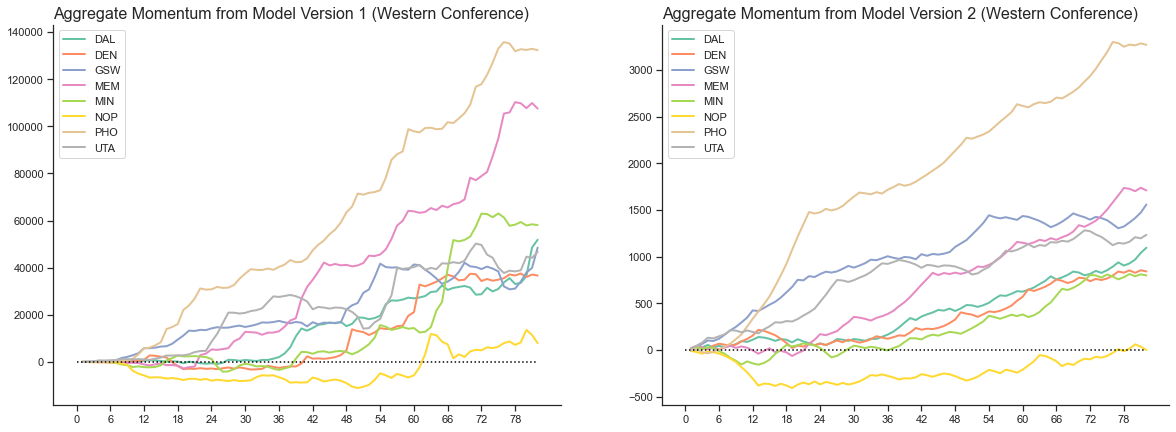

In [15]:
#---------------------------------------------------------------------------#
#                 Western Conference Momentum Model Comparison              #
#---------------------------------------------------------------------------#

fig, ax = plt.subplots(1, 2, sharex = True, figsize = (20, 7))
fontparams = {'font' : 'Arial', 'fontsize' : 16}

#-------------------- Model Version 1 --------------------------------------#

sns.set_palette("Set2")

ax[0].plot(data.loc[data.index.get_level_values('Team').isin(wc_playoff), 'MV1_M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'MV1_M'
    , index = 'Game'
    , aggfunc = np.sum
), linewidth = 2)

ax[0].legend(data.loc[data.index.get_level_values('Team').isin(wc_playoff), 'MV1_M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'MV1_M'
    , index = 'Game'
    , aggfunc = np.sum
).columns)

ax[0].set_title('Aggregate Momentum from Model Version 1 (Western Conference)'
                , fontdict = fontparams
                , loc = 'left')

ax[0].hlines(y = 0, xmin = 0, xmax = 82, color = 'black', linestyle = ':', alpha = 1)

#-------------------- Model Version 2 --------------------------------------#

ax[1].plot(data.loc[data.index.get_level_values('Team').isin(wc_playoff), 'M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'M'
    , index = 'Game'
    , aggfunc = np.sum
), linewidth = 2)

ax[1].legend(data.loc[data.index.get_level_values('Team').isin(wc_playoff), 'M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'M'
    , index = 'Game'
    , aggfunc = np.sum
).columns)

ax[1].hlines(y = 0, xmin = 0, xmax = 82, color = 'black', linestyle = ':', alpha = 1)

ax[1].set_title('Aggregate Momentum from Model Version 2 (Western Conference)'
                , fontdict = fontparams
                , loc = 'left')

ax[1].set_xticks(np.arange(0, 83, step = 6))

fig.savefig('wc_momentum_model_comparison_plot.png', dpi = 300)


fig.show()

In [ ]:
#---------------------------------------------------------------------------#
#                   Eastern Conference Model 2                              #
#---------------------------------------------------------------------------#

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette(sns.color_palette('hls', 8))

data.loc[data.index.get_level_values('Team').isin(ec_playoff), 'M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'M'
    , index = 'Game'
    , aggfunc = np.sum
).plot(figsize = (15, 7), linewidth = 2, alpha = .8, marker = '.')

plt.hlines(y = 0, xmin = 1, xmax = 82, color = 'black', linestyle = ':', linewidth = 1, alpha = .6)

plt.xticks(ticks = np.arange(1, 83, step = 4), labels = np.arange(1, 83, step = 4))


plt.xlabel('Game Number', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.ylabel('Total Momentum (M)', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.title('Total Season Momentum for the Eastern Conference Playoff Teams', fontdict = {'fontsize' : 16, 'font' : 'Arial'}, loc = 'left')

plt.savefig('ec_playoff_momentum.png', dpi = 300)
# plt.savefig('wc_playoff_momentum.png', dpi = 300)

plt.show()

In [ ]:
#---------------------------------------------------------------------------#
#                   Western Conference Model 2                              #
#---------------------------------------------------------------------------#

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette("Set2")

data.loc[data.index.get_level_values('Team').isin(wc_playoff), 'M'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'M'
    , index = 'Game'
    , aggfunc = np.sum
).plot(figsize = (15, 7), linewidth = 2, alpha = .8, marker = '.')

plt.hlines(y = 0, xmin = 1, xmax = 82, color = 'black', linestyle = ':', linewidth = 1, alpha = .6)

plt.xticks(ticks = np.arange(1, 83, step = 4), labels = np.arange(1, 83, step = 4))

plt.xlabel('Game Number', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.ylabel('Total Momentum (M)', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.title('Total Season Momentum for the Western Conference Playoff Teams', fontdict = {'fontsize' : 16, 'font' : 'Arial'}, loc = 'left')

plt.savefig('wc_playoff_momentum.png', dpi = 300)

plt.show()

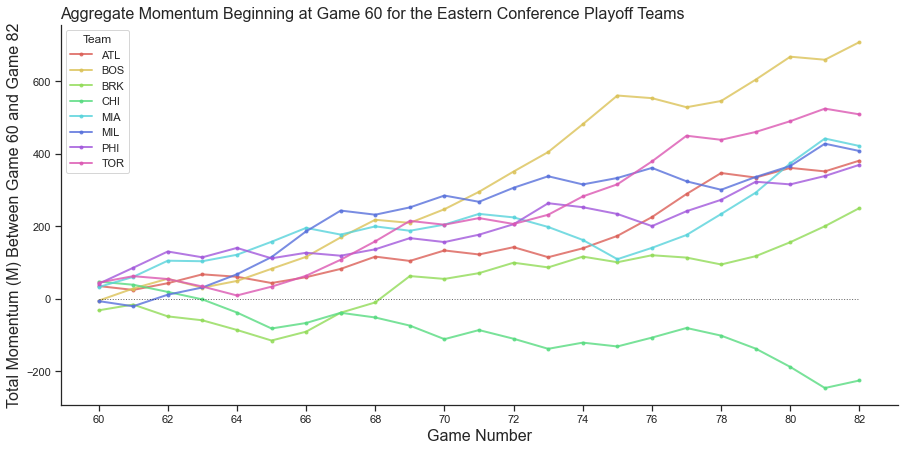

In [24]:
#----------------------------------------------------------------------------------------------------------#
#                         Eastern Coference Momentum Plot for Final 22 Games                               #
#----------------------------------------------------------------------------------------------------------#

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette(sns.color_palette('hls', 8))

data.loc[(data.index.get_level_values('Team').isin(ec_playoff)) & 
            (data.index.get_level_values('Game') >= 60), 
            'm'].reset_index().pivot_table(
            columns = 'Team'
            , values = 'm'
            , index = 'Game'
            , aggfunc = np.sum
        ).cumsum().plot(figsize = (15, 7), linewidth = 2, alpha = .8, marker = '.')

plt.hlines(y = 0, xmin = 60, xmax = 82, color = 'black', linestyle = ':', linewidth = 1, alpha = .6)

plt.xticks(ticks = np.arange(60, 83, step = 2), labels = np.arange(60, 83, step = 2))

plt.xlabel('Game Number', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.ylabel('Total Momentum (M) Between Game 60 and Game 82', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.title('Aggregate Momentum Beginning at Game 60 for the Eastern Conference Playoff Teams', fontdict = {'fontsize' : 16, 'font' : 'Arial'}, loc = 'left')

plt.savefig('ec_playoff_momentum_game_sixty.png', dpi = 300)

plt.show()

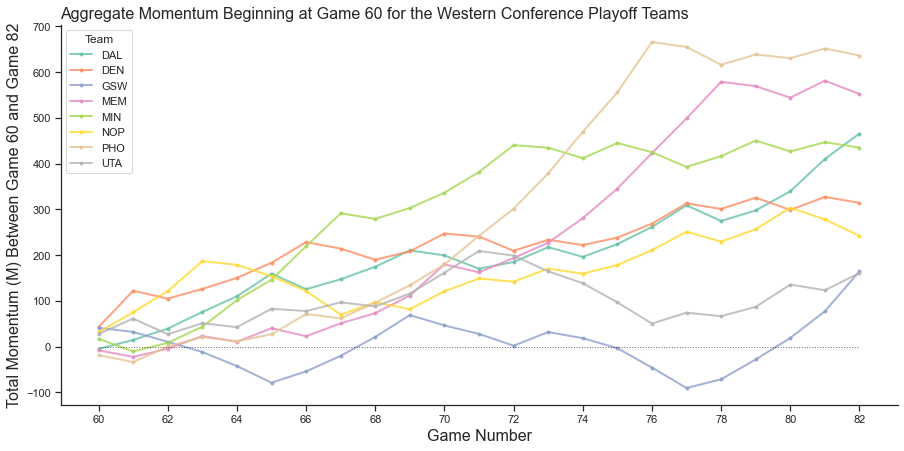

In [23]:
#----------------------------------------------------------------------------------------------------------#
#                         Western Coference Momentum Plot for Final 22 Games                               #
#----------------------------------------------------------------------------------------------------------#

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette("Set2")

data.loc[(data.index.get_level_values('Team').isin(wc_playoff)) & 
            (data.index.get_level_values('Game') >= 60), 
            'm'].reset_index().pivot_table(
            columns = 'Team'
            , values = 'm'
            , index = 'Game'
            , aggfunc = np.sum
        ).cumsum().plot(figsize = (15, 7), linewidth = 2, alpha = .8, marker = '.')

plt.hlines(y = 0, xmin = 60, xmax = 82, color = 'black', linestyle = ':', linewidth = 1, alpha = .6)

plt.xticks(ticks = np.arange(60, 83, step = 2), labels = np.arange(60, 83, step = 2))

plt.xlabel('Game Number', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.ylabel('Total Momentum (M) Between Game 60 and Game 82', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.title('Aggregate Momentum Beginning at Game 60 for the Western Conference Playoff Teams', fontdict = {'fontsize' : 16, 'font' : 'Arial'}, loc = 'left')

plt.savefig('wc_playoff_momentum_game_sixty.png', dpi = 300)

plt.show()

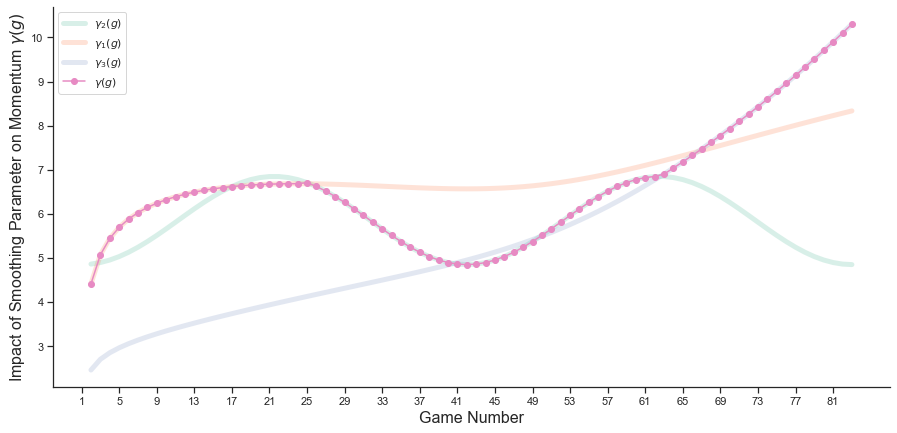

In [19]:
#---------------------------------------------------------------------------#
#                   Smoothing Parameter Visual                              #
#---------------------------------------------------------------------------#

games_vector = np.arange(1, 83, step = 1)

smoothing_1 = (((1/3) * games_vector ** 3) - ((64/2) * games_vector ** 2) + (943 * games_vector))

smoothing_6 = (-1 * np.cos(2 * np.pi * ((np.absolute(games_vector - 41)/41)))) + 5.85

smoothing_df = pd.DataFrame(smoothing_6)
smoothing_df.columns = ['PARAMETER_1']

smoothing_df['GAME'] = np.arange(1, 83, step = 1)

smoothing_df['PARAMETER_2'] = np.log(smoothing_1) - 2.4

smoothing_df['PARAMETER_3'] = np.sqrt( smoothing_df['PARAMETER_2'] ** (1.2 + (smoothing_df['GAME'] / 82)) )

smoothing_df['GAMMA'] = np.nan

smoothing_df.loc[(smoothing_df['GAME'] < 24), 'GAMMA'] = smoothing_df.loc[(smoothing_df['GAME'] < 24), 'PARAMETER_2']
smoothing_df.loc[(smoothing_df['GAME'] >= 24) &
                 (smoothing_df['GAME'] <= 61), 'GAMMA'] = smoothing_df.loc[(smoothing_df['GAME'] >= 24) &
                                                                           (smoothing_df['GAME'] <= 61), 'PARAMETER_1']
smoothing_df.loc[(smoothing_df['GAME'] > 61), 'GAMMA'] = smoothing_df.loc[(smoothing_df['GAME'] > 61), 'PARAMETER_3']

smoothing_df.set_index('GAME', inplace = True)

#-- Visualize Smoothing Parameter --#

plt.figure(figsize = (15, 7))

sns.set_palette('Set2')
font_params = {'fontsize' : 16, 'font' : 'Arial'}

plt.plot(smoothing_df.PARAMETER_1
            #, linestyle = ':'
            , alpha = .25
            #, color = color_palette[4]
            , linewidth = 5)

plt.plot(smoothing_df.PARAMETER_2
            #, linestyle = ':'
            , alpha = .25
            #, color = color_palette[2]
            , linewidth = 5)

plt.plot(smoothing_df.PARAMETER_3
            #, linestyle = ':'
            , alpha = .25
            #, color = color_palette[3]
            , linewidth = 5)

plt.plot(smoothing_df.GAMMA
            #, color = color_palette[0]
            , marker = 'o')

plt.xticks(ticks = np.arange(0, 83, step = 4), labels = np.arange(1, 83, step = 4))

plt.xlabel('Game Number'
            , font_params)
plt.ylabel('Impact of Smoothing Parameter on Momentum $\gamma(g)$'
            , fontdict = font_params)
plt.legend(['$\gamma_{2}(g)$', '$\gamma_{1}(g)$', '$\gamma_{3}(g)$', '$\gamma (g)$' ])

plt.savefig('gamma_visualized.png', dpi = 300)

plt.show()

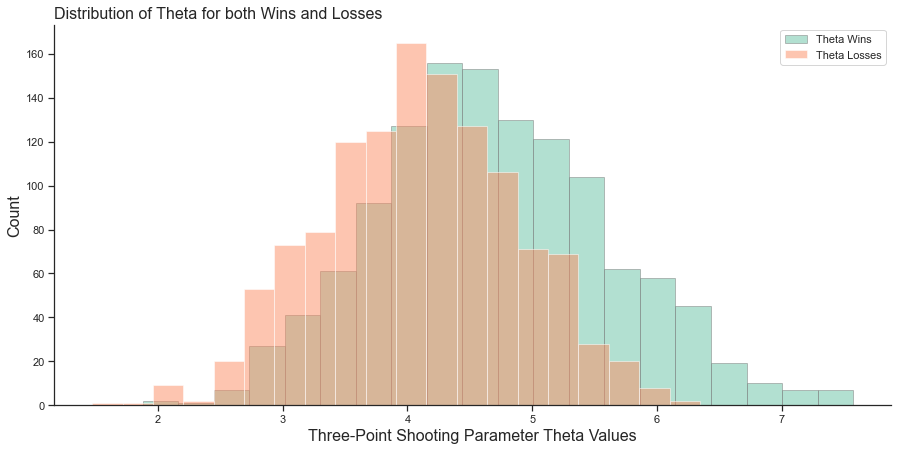

In [20]:
#----------------------------------------------------#
#                 Visualize Theta                    #
#----------------------------------------------------#

plt.figure(figsize = (15, 7))

plt.hist(data.loc[data['win_binary'] == 1, 'Theta'], alpha = .5, ec = 'grey', bins = 20)
plt.hist(data.loc[data['win_binary'] == 0, 'Theta'], alpha = .5, bins = 20)

plt.legend(['Theta Wins', 'Theta Losses'])

plt.xlabel('Three-Point Shooting Parameter Theta Values', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.ylabel('Count', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.title('Distribution of Theta for both Wins and Losses', fontdict = {'fontsize' : 16, 'font' : 'Arial'}, loc = 'left')

plt.savefig('theta_distribution.png', dpi = 300)

plt.show()

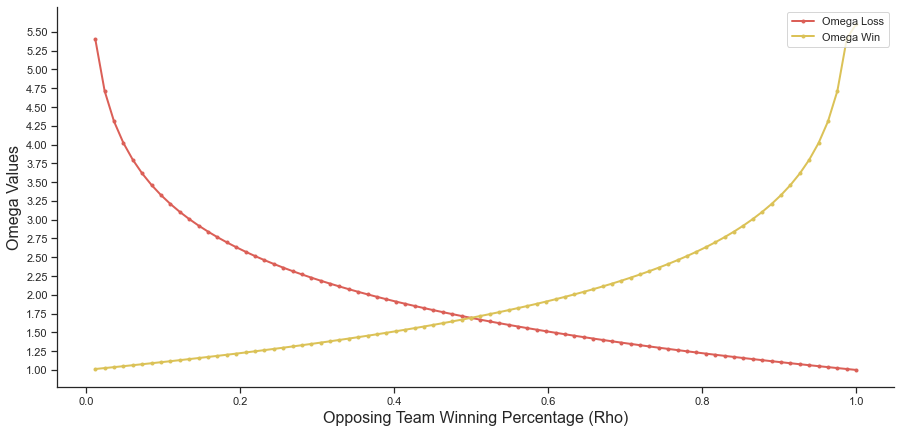

In [35]:
#----------------------------------------------------#
#                 Visualize Omega                    #
#----------------------------------------------------#

wldf = pd.DataFrame(pd.Series(np.arange(1, 83, 1)))
wldf.columns = ['GAME']

wldf['WINPER'] = wldf['GAME'] / 82
wldf['LP1'] = np.exp(1 - wldf.GAME / 82) ** 1.5 
wldf['WP1'] = np.log(1 - np.minimum(wldf.GAME / 82, .99)) * -1 + 1
wldf['LP2'] = np.log( 1 / wldf.WINPER ) + 1 
wldf['WP2'] = np.log( 1 / (1 - np.minimum(wldf.WINPER, .99) ) ) + 1

#-- Visualize Impacts
plt.figure(figsize = (15 , 7))

plt.plot(wldf.WINPER, wldf.LP2, linewidth = 2, marker = '.')
plt.plot(wldf.WINPER, wldf.WP2, linewidth = 2, marker = '.')

plt.xlabel('Opposing Team Winning Percentage (Rho)', fontdict = fontparams)
plt.ylabel('Omega Values', fontdict = fontparams)

plt.yticks(np.arange(wldf.LP2.min(), wldf.WP2.max(), step = .25))

plt.legend(['Omega Loss', 'Omega Win'], loc = 'upper right')

plt.savefig('omega_values_visual.png', dpi = 300)

plt.show()

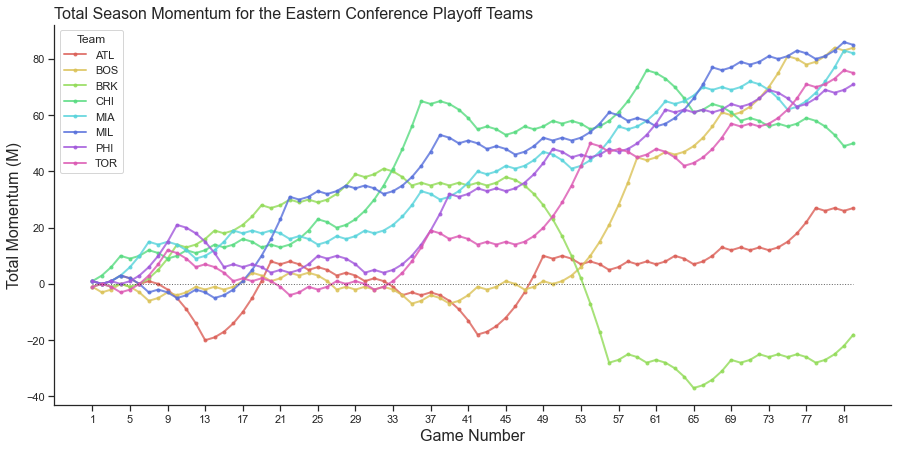

In [42]:
#----------------------------------------------------#
#                 Visualize Zeta                     #
#----------------------------------------------------#

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette(sns.color_palette('hls', 8))

data.loc[data.index.get_level_values('Team').isin(ec_playoff), 'Zeta'].reset_index().pivot_table(
    columns = 'Team'
    , values = 'Zeta'
    , index = 'Game'
    , aggfunc = np.sum
).cumsum().plot(figsize = (15, 7), linewidth = 2, alpha = .8, marker = '.')

plt.hlines(y = 0, xmin = 1, xmax = 82, color = 'black', linestyle = ':', linewidth = 1, alpha = .6)

plt.xticks(ticks = np.arange(1, 83, step = 4), labels = np.arange(1, 83, step = 4))

plt.xlabel('Game Number', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.ylabel('Cumulative Sum of Zeta', fontdict = {'fontsize' : 16, 'font' : 'Arial'})
plt.title('Cumulative Sum of Zeta for Eastern Conference Playoff Teams', fontdict = {'fontsize' : 16, 'font' : 'Arial'}, loc = 'left')

# plt.savefig('ec_playoff_momentum.png', dpi = 300)
# plt.savefig('wc_playoff_momentum.png', dpi = 300)

plt.show()

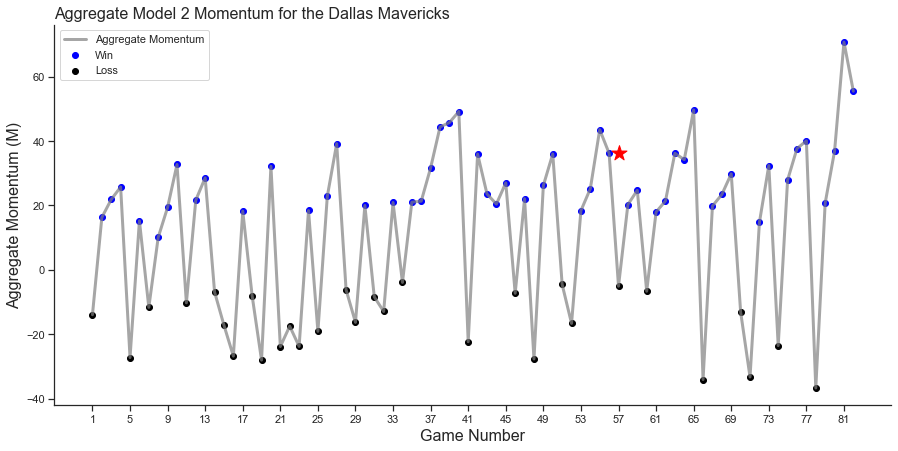

In [81]:
plt.figure(figsize = (15, 7))

M_vec = data.loc[data.index.get_level_values("Team") == 'DAL', 'm'].reset_index()['m']
Win_vec = data.loc[data.index.get_level_values("Team") == 'DAL', 'win_binary'].reset_index()['win_binary']

M_56 = data.loc[(data.index.get_level_values("Team") == 'DAL') & (data.index.get_level_values("Game") == 56), 'm'].reset_index()['m']

plt.plot(data.loc[data.index.get_level_values("Team") == 'DAL', 'm'].reset_index()['m'], linewidth = 3, color = 'grey', alpha = .7)
plt.scatter(x = data.index.get_level_values('Game').unique() - 1, y = np.where(Win_vec == 1, M_vec, np.nan), color = 'blue', alpha = 1)
plt.scatter(x = data.index.get_level_values('Game').unique() - 1, y = np.where(Win_vec == 0, M_vec, np.nan), color = 'black', alpha = 1)
plt.scatter(x = 56, y = M_56, s = 250, marker = '*', color = 'red', alpha = 1)


plt.xticks(np.arange(0, 83, step = 4), np.arange(1, 83, step = 4))
plt.xlabel('Game Number', fontdict = fontparams)
plt.ylabel('Aggregate Momentum (M)', fontdict = fontparams)

plt.legend(['Aggregate Momentum', 'Win', 'Loss'])
plt.title('Aggregate Model 2 Momentum for the Dallas Mavericks', fontdict = fontparams, loc = 'left')

plt.savefig('mavs_momentum_visualized.png', dpi = 300)

plt.show()

In [99]:
#------------------------------------------------------#
#                   Team Sharpe Ratios                 #
#------------------------------------------------------#

#-- NBA Sharpe = [ X_tm.mean() / X_tm.std() ] - [ X_opp.mean() / X_opp.std() ]

x = pd.DataFrame(pd.Series(data['Tm'].groupby('Team').mean() / data['Tm'].groupby('Team').std()))
x['Opp'] = data['Opp'].groupby('Team').mean() / data['Opp'].groupby('Team').std()
x['Diff'] = x['Tm'] - x['Opp']
print(x['Diff'].sort_values(ascending=False))

Team
NOP    2.176434
NYK    1.317508
IND    1.314938
CLE    1.244379
OKC    0.949449
PHO    0.891655
ORL    0.881237
UTA    0.512499
MIN    0.425391
BOS    0.093897
BRK    0.035315
MIL   -0.050204
GSW   -0.051844
CHI   -0.113432
LAL   -0.119596
SAS   -0.190290
DET   -0.207054
CHO   -0.252322
POR   -0.420672
LAC   -0.450493
HOU   -0.511887
DEN   -0.556049
WAS   -0.633903
MEM   -0.761193
DAL   -0.884225
ATL   -0.914397
TOR   -0.925005
MIA   -1.249202
PHI   -1.279578
SAC   -3.107928
Name: Diff, dtype: float64
